## My bicycle reinvention in module import issue  

In [1]:
from lib import *

Pipeline = pipeline.Pipeline
RegressionValidator = pipeline.RegressionValidator

DatasetProvider = provider.DatasetProvider
DatasetUploader = provider.DatasetUploader
ExpandedWindowIterator = subset_extraction.ExpandedWindowIterator
EntityIterator = subset_extraction.EntityIterator


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy
from scipy import stats

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import LabelEncoder

tr = transformers

In [3]:
df_provider = DatasetProvider()

In [4]:
dataset_paths = [
    '/home/denissimo/Repo/fs_project/datasets/sample_submission.csv',
    '/home/denissimo/Repo/fs_project/datasets/test.csv',
    '/home/denissimo/Repo/fs_project/datasets/shops.csv',
    '/home/denissimo/Repo/fs_project/datasets/item_categories.csv',
    '/home/denissimo/Repo/fs_project/datasets/sales_train.csv',
    '/home/denissimo/Repo/fs_project/datasets/items.csv'
]

In [5]:
df_provider.file_list = dataset_paths

datasets = df_provider.get_dataset()

In [6]:
sales = datasets['sales_train.csv']
items = datasets['items.csv']
categories = datasets['item_categories.csv']
shops = datasets['shops.csv']

In [7]:
force_category = {
    'category': {
        "PC - Гарнитуры/Наушники": "Аксессуары",
        "Игры MAC - Цифра": "Игры",
        "Игры Android - Цифра": "Игры",
        "Чистые носители (шпиль)": "Чистые носители",
        "Чистые носители (штучные)": "Чистые носители",
    },
    'shop': {
        'Интернет-магазин ЧС': 'Интернет-магазин',
        'Цифровой склад 1С-Онлайн': 'Склад',
        'Выездная Торговля': 'Выездная Торговля',
        '!Якутск Орджоникидзе, 56 фран': 'Якутск',
        '!Якутск ТЦ "Центральный" фран': 'Якутск',
    },
}

pattern = {
    'category': ' - ',
    'shop': ' ',
}

In [8]:
sales.date = sales.date.astype('datetime64[ns]')

print("Before:", sales.shape)

from datetime import date

sales = sales.loc[sales.date < np.datetime64(date(2015, 11, 1))]

sales_train = sales[
    (sales["item_cnt_day"] < 1000)
    & (sales["item_price"] > 0)
    & (sales["item_price"] < 60000)
].copy()
print("After:", sales_train.shape)

sales.head()

Before: (2935849, 6)
After: (2896778, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [9]:
make_cat_name = tr.create_name_transformer(force_category['category'], pattern['category'])
make_city_name = tr.create_name_transformer(force_category['shop'], pattern['shop'])

In [10]:
data_preprocessing = {}

# Add corresponding category and shop id's to each sale
data_preprocessing['id_merging_stage'] = lambda dataset: dataset.merge(
    items, 
    on='item_id'
).merge(
    shops,
    on='shop_id'
).merge(
    categories,
    on='item_category_id'
)

# Add summary among shop_id and category_id above similar time periods (daily intervals)
data_preprocessing['summarizing_and_name_merging_stage'] = lambda dataset: dataset.groupby(
    ['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_category_name', 'shop_name']
).item_cnt_day.sum().reset_index().sort_values('date')

data_preprocessing['add_generalized_names_and_encode_stage'] = lambda dataset: tr.append_columns(
    dataset=dataset, 
    columns=[
        'global_item_category_name',
        'city_name',
        'global_item_category_name_id',
        'city_id',
    ], 
    transformers=[
        lambda _dataset: _dataset["item_category_name"].apply(
            make_cat_name
        ),
        lambda _dataset: _dataset['shop_name'].apply(
            make_city_name
        ),
        lambda _dataset: LabelEncoder().fit_transform(_dataset['global_item_category_name']),
        lambda _dataset: LabelEncoder().fit_transform(_dataset['city_name']),
    ]
)

        
data_preprocessing['date_block_num_renaming'] = lambda dataset: dataset.rename(columns={'date_block_num': 'month_block'}, inplace=True)
        
data_preprocessing['date_encoding_stage'] = lambda dataset: tr.append_columns(
    dataset=dataset, 
    columns=[
        'week_block',
        'day_block',
    ], 
    transformers=[
        lambda _dataset: LabelEncoder().fit_transform(_dataset['date'].dt.to_period('W')),
        lambda _dataset: LabelEncoder().fit_transform(_dataset['date'].dt.to_period('D')),
    ]
)

data_preprocessing['create_full_matrix_stage'] = lambda _dataset: _dataset.set_index('date') \
    .groupby([
        'shop_id',
        'item_category_id',
        'month_block',
        'city_id',
        'global_item_category_name_id',
        'id'
    ]).item_cnt_day.sum() \
    .reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'}) \
    .groupby(['shop_id', 'item_category_id', 'month_block', 'city_id', 'global_item_category_name_id', 'id']).item_cnt_month.sum().reset_index() \
    .groupby(['month_block', 'id']).item_cnt_month.sum().unstack().fillna(0) \
    .stack().reset_index().rename(columns={0:'item_cnt_month'})

In [11]:
pipeline = Pipeline(
    tasks=data_preprocessing, 
    task_queue = [
        'id_merging_stage',
        'summarizing_and_name_merging_stage',
        'add_generalized_names_and_encode_stage',
        'date_block_num_renaming',
        'date_encoding_stage',
    ]
)

In [12]:
pipeline_test = pipeline(sales)
pipeline_train = pipeline(sales_train)

_ = pipeline_test.proceed_all()
_ = pipeline_train.proceed_all()

Stage - id_merging_stage complete
Stage - summarizing_and_name_merging_stage complete
Stage - add_generalized_names_and_encode_stage complete
Stage - date_block_num_renaming complete
Stage - date_encoding_stage complete
Stage - id_merging_stage complete
Stage - summarizing_and_name_merging_stage complete
Stage - add_generalized_names_and_encode_stage complete
Stage - date_block_num_renaming complete
Stage - date_encoding_stage complete


In [13]:
task_df = {}

task_df['test'] = pipeline_test.result_storage['date_encoding_stage']
task_df['train'] = pipeline_train.result_storage['date_encoding_stage']

In [14]:
idx = task_df['test'].loc[:,['city_id', 'global_item_category_name_id', 'city_name', 'global_item_category_name']].value_counts().sort_index()
idx = pd.DataFrame({'id': [i for i in range(idx.size)]}, idx.index)
idx.reset_index(inplace=True)

In [15]:
task_df['test'] = task_df['test'].merge(idx, on=['city_id', 'global_item_category_name_id', 'city_name', 'global_item_category_name'])
task_df['train'] = task_df['train'].merge(idx, on=['city_id', 'global_item_category_name_id', 'city_name', 'global_item_category_name'])

In [16]:
idx['pair_name'] = idx['city_name'] + ' - ' + idx['global_item_category_name']

In [17]:
task_df_copy = {}

task_df_copy['train'] = task_df['train'].copy()
task_df_copy['test'] = task_df['test'].copy()
task_df['test']['pair_name'] = task_df['test']['city_name'] + ' - ' + task_df['test']['global_item_category_name']

task_df['train'] = data_preprocessing['create_full_matrix_stage'](task_df['train'])
task_df['test'] = data_preprocessing['create_full_matrix_stage'](task_df['test'])

In [18]:
task_df['train']

,month_block,id,item_cnt_month
0,0,0,66.0
1,0,1,0.0
2,0,2,20.0
3,0,3,240.0
4,0,4,263.0
...,...,...,...
14887,33,433,87.0
14888,33,434,98.0
14889,33,435,14.0
14890,33,436,12.0


In [19]:
sample_df = task_df['train'][task_df['train'].id == 3]

In [20]:
CONFIG = {
    'validation_window': {
        'min_window': 24,
        'max_window': 31,
    },
    'training_window': {
        'min': 16
    }
}

In [21]:
def add_aggregation(feature_set, series, name):
    feature_set[name + '_mean'] = series.mean()
    feature_set[name + '_std'] = series.std()

def target_extractor(month):
    return task_df['train'][task_df['train'].month_block == month + 1][['id', 'item_cnt_month']].set_index('id').sort_index()

In [22]:
iteration_rule = ExpandedWindowIterator('month_block', target_extractor, min_idx=CONFIG['validation_window']['min_window'], step=1, max_idx=CONFIG['validation_window']['max_window'])

In [23]:
subset_extractor = EntityIterator('id')

In [33]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]

def get_category_serires(df):
    category_id = df.id.value_counts().unique()[0]

In [34]:
def generate_feature_row(split_x, target, window, _id):
    
    _feature_set = {}
    _serieses = {}

    _feature_set['window'] = window
    _feature_set['id'] = _id

    _sale_series = split_x.set_index('month_block').item_cnt_month

    _serieses[f'lag_1'] = tr.lag(_sale_series, 1, 0)
    _serieses['diff_1'] = tr.diff(_sale_series, 1)
    _serieses['diff_2'] = tr.diff(_sale_series, 2)

    for i in range(1,13):
        _feature_set[f'lag_{i}'] = _serieses['lag_1'].to_list()[-i]

    for i in range(1,7):
        _feature_set[f'diff_1_{i}'] = _serieses['diff_1'].to_list()[-i]

    for i in range(1,7):
        _feature_set[f'diff_2_{i}'] = _serieses['diff_2'].to_list()[-i]
    
    add_aggregation(_feature_set, _sale_series, '')
    add_aggregation(_feature_set, _sale_series[-12:], 'last_12')
    add_aggregation(_feature_set, _sale_series[-6:], 'last_6')
    add_aggregation(_feature_set, _sale_series[-2:], 'last_2')
    add_aggregation(_feature_set, _serieses['diff_1'], 'diff_1')
    add_aggregation(_feature_set, _serieses['diff_2'], 'diff_2')
    add_aggregation(_feature_set, _serieses['diff_1'][-12:], 'diff_1_last_12')
    add_aggregation(_feature_set, _serieses['diff_1'][-6:], 'diff_1_last_6')
    add_aggregation(_feature_set, _serieses['diff_1'][-2:], 'diff_1_last_2')
    _feature_set['last_observed'] = _sale_series.values[-1]
    _feature_set['time'] = _sale_series.index[-1]
    _feature_set['month_number'] = _feature_set['time'] % 12
    _feature_set['days_in_month'] = DAYS[_feature_set['month_number']]
    _feature_set['target'] = target

    return pd.DataFrame(_feature_set.items()).set_index(0).transpose()

In [35]:
train = None

for window, split_x, split_y in iteration_rule(task_df['train']):
    as_list = split_y.item_cnt_month.to_list()
    for _id, subset in subset_extractor(split_x):
        new_feature = generate_feature_row(subset, as_list[_id], window, _id)
        if train is None:
            train = new_feature
        else:
            train = pd.concat([train, new_feature])
        

In [36]:
train = train.reset_index().drop('index', axis=1)

In [40]:
train

,window,id,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,diff_1_last_12_std,diff_1_last_6_mean,diff_1_last_6_std,diff_1_last_2_mean,diff_1_last_2_std,last_observed,time,month_number,days_in_month,target
0,24.0,0.0,86.0,30.0,35.0,55.0,48.0,28.0,41.0,35.0,...,25.310646,3.500000,32.574530,9.5,65.760931,49.0,24.0,0.0,31.0,16.0
1,24.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,1.705606,0.000000,2.529822,0.0,0.000000,0.0,24.0,0.0,31.0,0.0
2,24.0,2.0,36.0,10.0,15.0,14.0,15.0,13.0,11.0,17.0,...,19.994696,-0.500000,16.622274,0.0,36.769553,10.0,24.0,0.0,31.0,2.0
3,24.0,3.0,789.0,509.0,325.0,333.0,381.0,343.0,312.0,364.0,...,175.823172,1.166667,248.507880,-79.5,508.409776,350.0,24.0,0.0,31.0,280.0
4,24.0,4.0,297.0,271.0,230.0,202.0,219.0,198.0,298.0,251.0,...,55.768121,-2.000000,56.864752,-42.5,96.873629,186.0,24.0,0.0,31.0,159.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3499,31.0,433.0,105.0,77.0,106.0,95.0,97.0,73.0,94.0,159.0,...,29.484459,1.500000,23.839044,2.5,36.062446,82.0,31.0,7.0,31.0,64.0
3500,31.0,434.0,208.0,182.0,123.0,127.0,215.0,243.0,226.0,397.0,...,78.552241,-8.500000,50.046978,5.0,29.698485,192.0,31.0,7.0,31.0,120.0
3501,31.0,435.0,17.0,9.0,12.0,13.0,20.0,14.0,25.0,32.0,...,6.529073,-0.500000,6.220932,1.0,9.899495,11.0,31.0,7.0,31.0,13.0
3502,31.0,436.0,30.0,10.0,13.0,19.0,25.0,22.0,25.0,34.0,...,11.975986,-0.666667,11.236844,4.0,22.627417,18.0,31.0,7.0,31.0,28.0


In [37]:
target_test = task_df['test'].rename(columns={'month_block': 'window', 'item_cnt_month': 'target'})

In [38]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV

errors = {}

<AxesSubplot:ylabel='Count'>

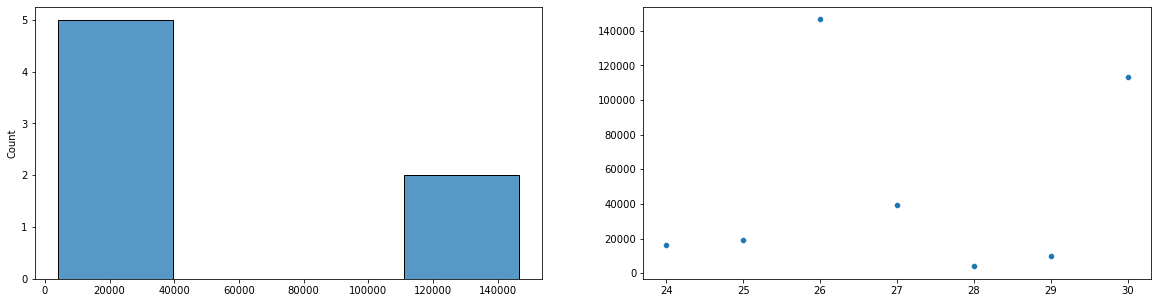

In [41]:
validator_lin = RegressionValidator(LinearRegression)
errors['original'] = validator_lin.validate(CONFIG['validation_window'], train, target_test)

_, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.scatterplot(x=errors['original'][0], y=errors['original'][1], ax=axs[1])
sns.histplot(errors['original'][1], ax=axs[0])

In [42]:
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'